# CatBoost

In [9]:
import pandas as pd
import joblib
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils import load_and_prepare_data, evaluate_metrics, plot_roc_curve, optimize_threshold

In [3]:
df = pd.read_parquet("../diabetes_dataset_prepared.parquet")
X_train, X_test, y_train, y_test = load_and_prepare_data(df)

We will try an untuned model and see how it performs.

In [4]:
cat_untuned = CatBoostClassifier(random_seed=2025, verbose=0)
cat_untuned.fit(X_train, y_train)

In [5]:
y_train_pred = cat_untuned.predict(X_train)
y_test_pred = cat_untuned.predict(X_test)

Training Set Metrics:


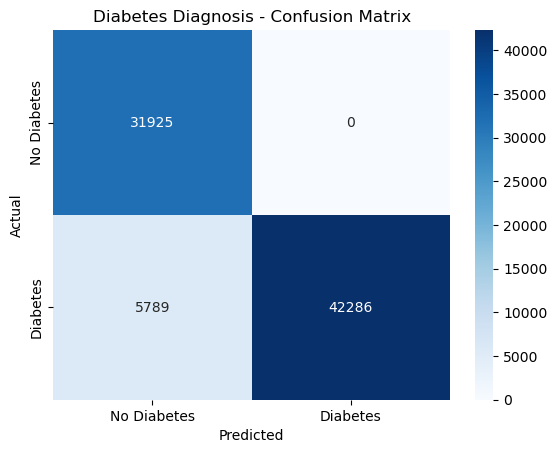

Accuracy: 0.9276375
Precision: 1.0
Recall: 0.8795839833593344
F1 Score: 0.9359347506114364


Test Set Metrics:


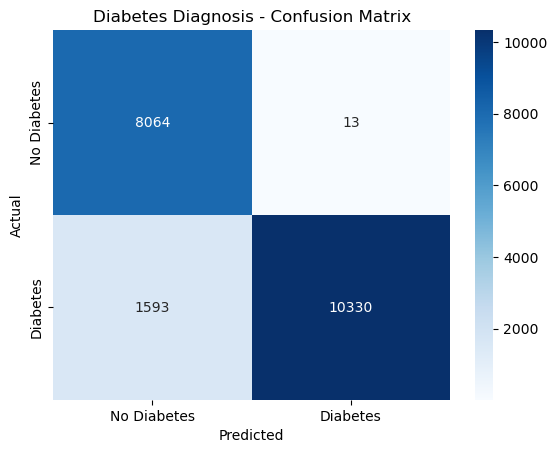

Accuracy: 0.9197
Precision: 0.9987431112829933
Recall: 0.8663926864044285
F1 Score: 0.9278720919788017


In [6]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

This is the best recall thus far, but it came at the expense of precision. Let's see if we can get the same performance with only 2 variables.

In [7]:
cat_untuned_2 = CatBoostClassifier(random_seed=2025, verbose=0)
cat_untuned_2.fit(X_train[:, [4, 6]], y_train)

y_train_pred = cat_untuned_2.predict(X_train[:, [4, 6]])
y_test_pred = cat_untuned_2.predict(X_test[:, [4, 6]])

Training Set Metrics:


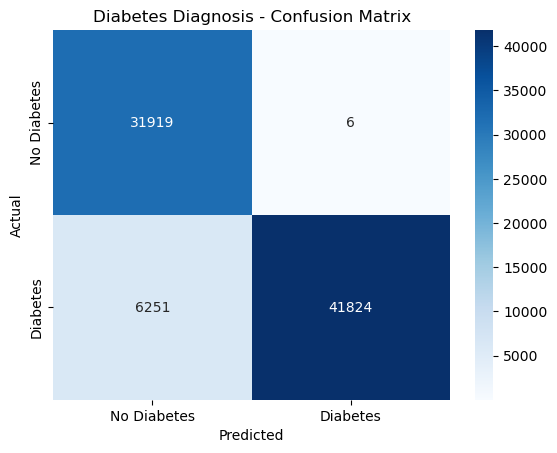

Accuracy: 0.9217875
Precision: 0.9998565622758786
Recall: 0.8699739989599584
F1 Score: 0.9304043156665369


Test Set Metrics:


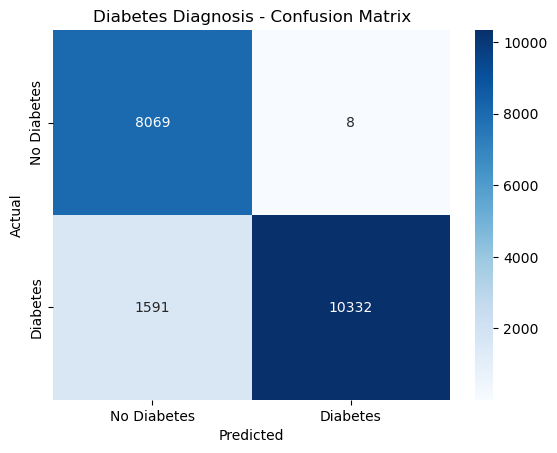

Accuracy: 0.92005
Precision: 0.9992263056092844
Recall: 0.8665604294221253
F1 Score: 0.9281767955801105


In [8]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

Even Better! Brilliant! We will now try to optimize the hyperparameters. This is our best model so far in terms of recall, and it only uses two features, so we will opt for a slightly higher n_iter and cv than we did with some of the other models.

In [11]:
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'bagging_temperature': [0, 0.2, 0.5, 0.8, 1],
    'iterations': [500, 1000, 1500]
}

cbc = CatBoostClassifier(eval_metric='F1', verbose=0)
random_search = RandomizedSearchCV(
    cbc, 
    param_distributions=param_dist, 
    n_iter=100, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1
)
random_search.fit(X_train[:, [4, 6]], y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 1000, 'depth': 4, 'bagging_temperature': 1}


In [12]:
cat_1 = CatBoostClassifier(**best_params, random_seed=2025, verbose=0)
cat_1.fit(X_train[:, [4, 6]], y_train)

y_train_pred = cat_1.predict(X_train[:, [4, 6]])
y_test_pred = cat_1.predict(X_test[:, [4, 6]])

Training Set Metrics:


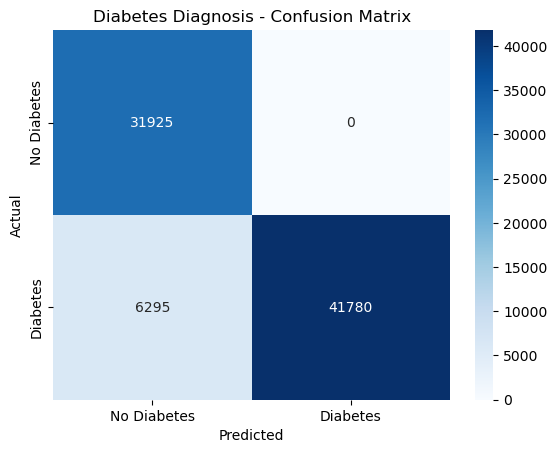

Accuracy: 0.9213125
Precision: 1.0
Recall: 0.8690587623504941
F1 Score: 0.9299426854376496


Test Set Metrics:


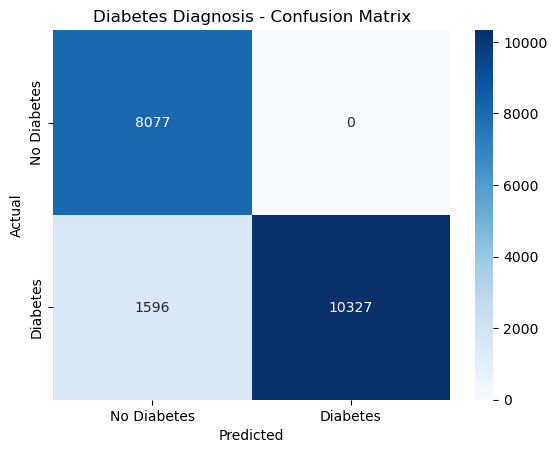

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [13]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

A bit underwhelming... Let's optimize the threshold and take a look at the roc curve.

In [14]:
y_train_pred_proba = cat_1.predict_proba(X_train[:, [4, 6]])[:, 1]
y_test_pred_proba = cat_1.predict_proba(X_test[:, [4, 6]])[:, 1]

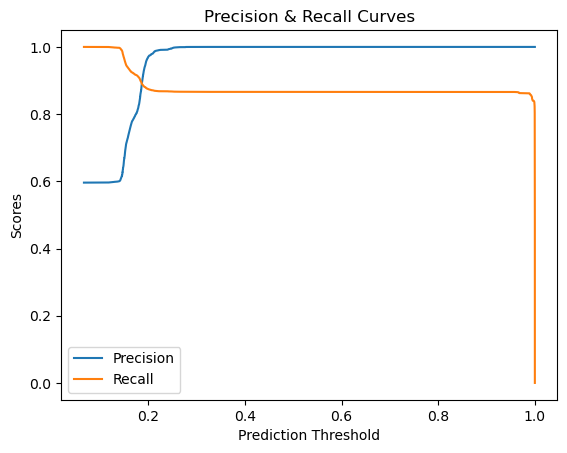

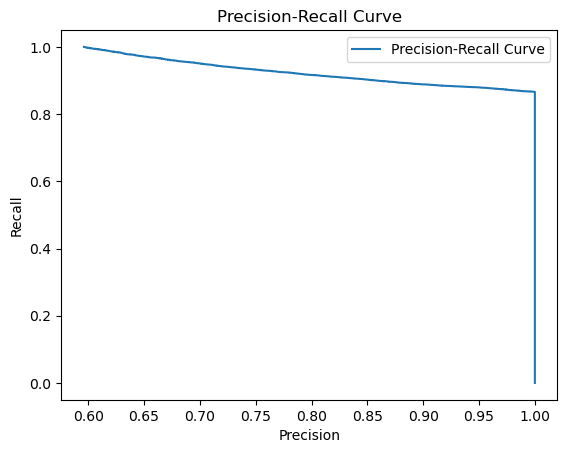

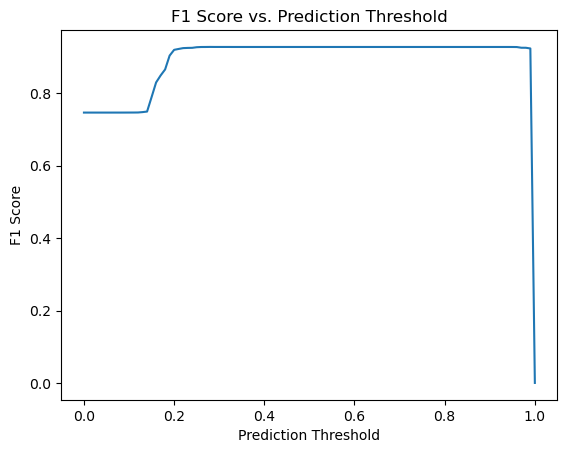

Optimal threshold: 0.28


In [15]:
thresh = optimize_threshold(y_test, y_test_pred_proba)
print(f"Optimal threshold: {thresh}")

In [16]:
preds_train = y_train_pred_proba >= thresh
preds_test = y_test_pred_proba >= thresh

Training Set Metrics with Optimized Threshold:


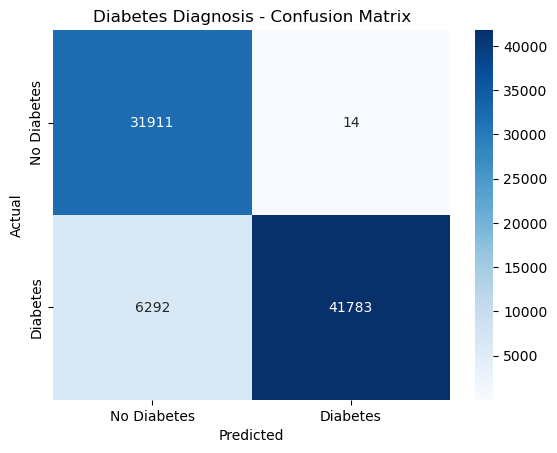

Accuracy: 0.921175
Precision: 0.9996650477306984
Recall: 0.8691211648465939
F1 Score: 0.9298335410361402


Test Set Metrics with Optimized Threshold:


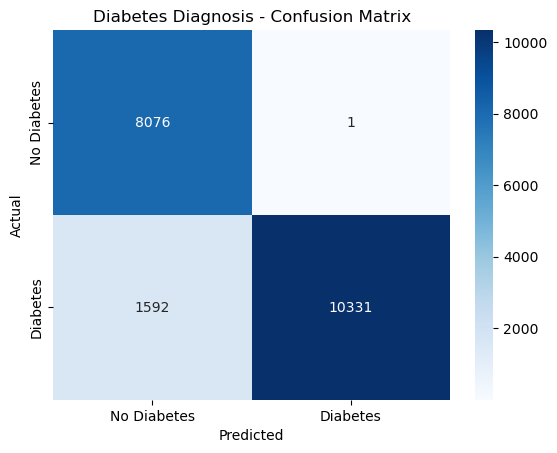

Accuracy: 0.92035
Precision: 0.9999032133178475
Recall: 0.8664765579132768
F1 Score: 0.9284205796450236


In [17]:
evaluate_metrics(y_train, preds_train, "Training Set Metrics with Optimized Threshold:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, preds_test, "Test Set Metrics with Optimized Threshold:")

This looks slightly better than any model thus far.

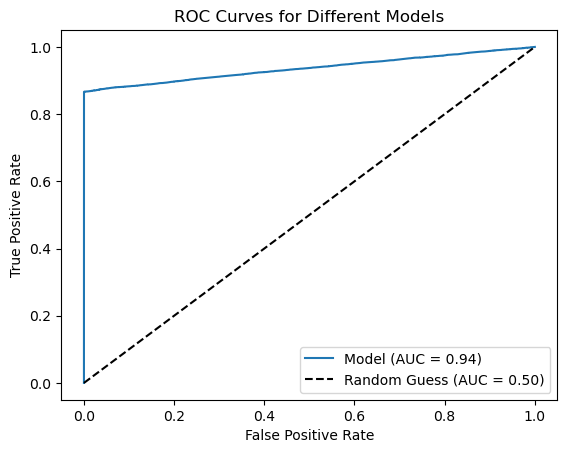

In [18]:
plot_roc_curve(y_test, y_test_pred_proba)

The ROC curve is 0.94, like the other models. Still, with an optimized threshold, this seems to be the best performing model, albeit by a very tiny margin.

In [19]:
joblib.dump(cat_1, "../models/cat_1.joblib")

['../models/cat_1.joblib']